## Generate Test Data

In [1]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy
import scipy
import sklearn.cross_validation

n = 50

x = scipy.linspace(0, 10, n)
y = numpy.polyval([3,-2,3,4], x)

noise = scipy.randn(n) * 0.7
x += noise
y += noise

x_train, x_test, y_train, y_test = sklearn.cross_validation.train_test_split(x, y, test_size=0.2)

# TODO break out validation and training error here?

## Using Math Helpers
### Plotting different model functions at different model complexities

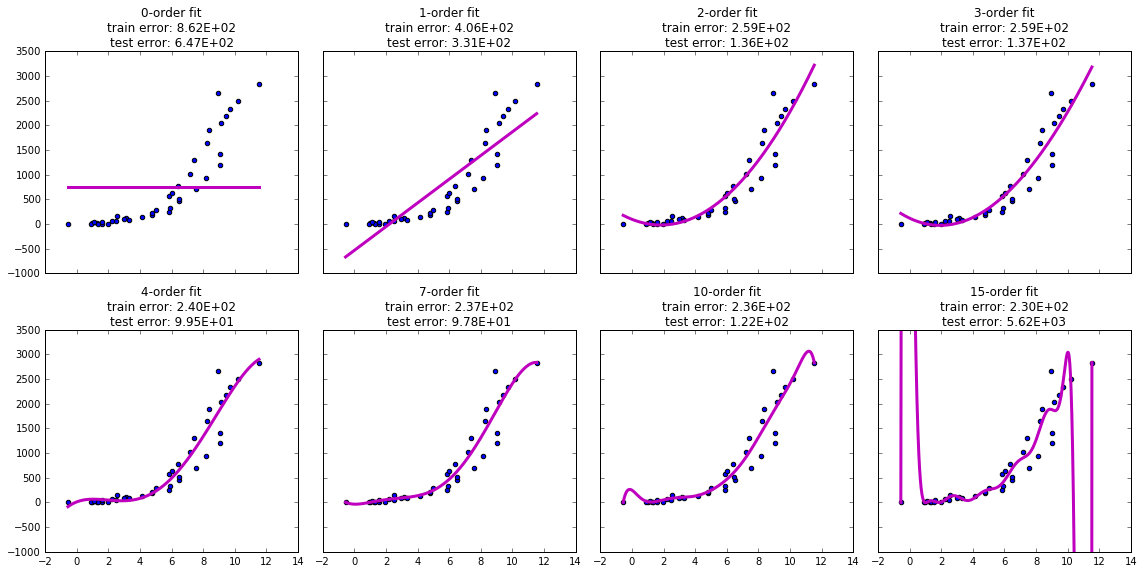

In [2]:
def get_error(x, y, params):
    predicted = numpy.polyval(params, x)
    diff = predicted - y
    sq_diff = numpy.dot(diff, diff)
    avg_sq_diff = sq_diff / x.size
    avg_diff = math.sqrt(avg_sq_diff)
    return avg_diff

n_rows = 2
n_cols = 4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, sharey=True, figsize=(16,8))
list_of_plot_pos = [(r,c) for r in range(n_rows) for c in range(n_cols)]

def add_plot_for_params(params):
    
    fx = scipy.linspace(numpy.min(x_train), numpy.max(x_train), 1000)
    fy = numpy.polyval(params, fx)
    
    train_error = get_error(x_train, y_train, params)
    test_error = get_error(x_test, y_test, params)
    
    (row,col) = list_of_plot_pos.pop(0)
    ax = axes[row, col]
    order = params.size - 1 # ignoring constant with respect to polynomial order
    ax.set_title('{0}-order fit\ntrain error: {1:.2E}\ntest error: {2:.2E}'.format(order, train_error, test_error))
    ax.scatter(x_train ,y_train)
    ax.autoscale(False) # autoscale based only on the scatterplot
    ax.plot(fx,fy, linewidth=3, c='m')

orders = [0,1,2,3,4,7,10,15]

for order in orders:
    params = scipy.polyfit(x_train , y_train, order)
    add_plot_for_params(params)

plt.tight_layout()
plt.show()

### Plot model complexity effect on test and training error

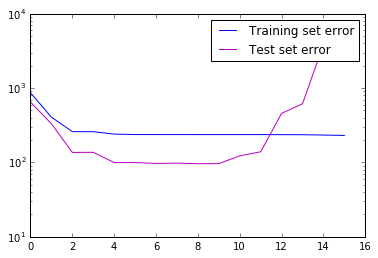

In [3]:
train_e = []
test_e = []
error_comparison_order_limit = 16
for n in range(error_comparison_order_limit):
    
    params = scipy.polyfit(x_train , y_train, n)
    fx = scipy.linspace(numpy.min(x_train), numpy.max(x_train), 1000)
    fy = numpy.polyval(params, fx)
    
    train_error = get_error(x_train, y_train, params)
    train_e.append(train_error)
    test_error = get_error(x_test, y_test, params) # should be using a validation set here
    test_e.append(test_error)
    
plt.semilogy(range(error_comparison_order_limit), train_e)
plt.semilogy(range(error_comparison_order_limit), test_e, c='m')
plt.legend(['Training set error', 'Test set error'])
plt.show()

## Using sklearn

/Users/matt/.virtualenvs/kaggle/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


order		test on training	kfold validation		true test
0		8.6E+02			9.2E+02				6.47E+02
1		1.2E+03			1.1E+03				9.79E+02
2		1.2E+03			1.1E+03				8.45E+02
3		1.2E+03			1.1E+03				8.47E+02
4		1.2E+03			1.1E+03				8.54E+02
5		1.2E+03			1.1E+03				8.52E+02
6		1.2E+03			1.1E+03				8.56E+02
7		1.2E+03			1.1E+03				8.56E+02
8		1.2E+03			1.2E+03				8.54E+02
9		1.2E+03			1.7E+03				8.54E+02
10		1.2E+03			2.6E+03				8.42E+02
11		1.2E+03			3.6E+03				8.39E+02
12		1.2E+03			7.1E+03				1.06E+03
13		1.2E+03			4.5E+04				8.80E+02
14		1.2E+03			1.8E+05				8.61E+02
15		1.2E+03			3.1E+05				8.63E+02
16		1.2E+03			7.6E+05				8.65E+02
17		1.2E+03			1.8E+06				8.67E+02
18		1.2E+03			1.8E+06				8.67E+02
19		1.2E+03			3.2E+06				8.57E+02
20		1.2E+03			5.5E+06				8.57E+02
21		1.2E+03			6.0E+06				8.57E+02
22		1.2E+03			9.5E+06				8.56E+02
23		1.2E+03			1.5E+07				8.56E+02
24		1.2E+03			2.4E+07				8.57E+02
25		1.2E+03			3.8E+07				8.51E+02
26		1.2E+03			6.2E+07				8.50E+02
27		1.2E+03			1.8E+07				8.49E+02
28		1.

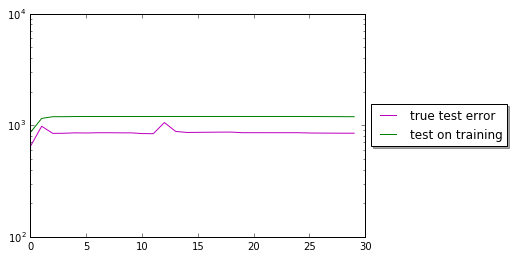

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def get_model(xs, ys, n_poly):
    rxs = xs.reshape(xs.size, 1) # must have shape of (size, 1) instead of (size, )
    rys = ys.reshape(ys.size, 1)

    poly = PolynomialFeatures(n_poly)
    alg = LinearRegression(fit_intercept=True)
    
    model = make_pipeline(poly, alg)
    model.fit(rxs, rys)
    
#     if n_poly == 0:
#         print(alg.coef_)
    
    return model


def get_predictions(model, xs):
        return model.predict(xs.reshape(xs.size, 1))
    
    
# FIXME -- maybe this squaring and square rooting is messing up with numbers less than 1 and
# that's why my test error is so low for 0-order polynomial fits

def get_avg_error(predictions, actuals):
    error = predictions - actuals
    sq_error = numpy.power(error, 2)
    total_sq_error = numpy.sum(sq_error)
    
    total_error = numpy.sqrt(total_sq_error)
    avg_error = total_error / predictions.size
    return avg_error
    
    
def get_poly_error(train__x, train__y, test__x, test__y, n_poly):
    model = get_model(train__x, train__y, n_poly)
    predictions = get_predictions(model, test__x)
#     if n_poly == 0:
#         print(predictions)
#         print(test__y)
    return get_avg_error(predictions, test__y)
    
    
max_poly_order = 30
poly_orders = range(max_poly_order)

kf = KFold(x_train.size, shuffle=True, n_folds=3)

kfold_validation_error_list = []
for n_poly in poly_orders:
    errors = []
    for train_index, test_index in kf:
        e = get_poly_error(x_train[train_index], 
                           y_train[train_index], 
                           x_train[test_index], 
                           y_train[test_index], 
                           n_poly)
        errors.append(e)
    diff = numpy.mean(errors)
    kfold_validation_error_list.append(diff)

true_test_error_list = [get_poly_error(x_train, 
                                  y_train, 
                                  x_test, 
                                  y_test, 
                                  o) for o in poly_orders]
test_on_training_error_list = [get_poly_error(x_train, 
                                              y_train, 
                                              x_train, 
                                              y_train, 
                                              o) for o in poly_orders]

print('order\t\ttest on training\tkfold validation\t\ttrue test')
for o in poly_orders:
    print('{0}\t\t{1:.1E}\t\t\t{2:.1E}\t\t\t\t{3:.2E}'.format(o, 
                                                    test_on_training_error_list[o], 
                                                    kfold_validation_error_list[o], 
                                                    true_test_error_list[o]))

best_order = kfold_validation_error_list.index(min(kfold_validation_error_list))
test_error = get_poly_error(x_train, y_train, x_test, y_test, best_order) 
print('best order per validation testing: {0}'.format(best_order))

#### FIXME why is 0-order test error so low? #####

plt.semilogy(poly_orders, true_test_error_list, c='m')
plt.semilogy(poly_orders, test_on_training_error_list, c='g')
# plt.semilogy(poly_orders, kfold_validation_error_list)
plt.legend(['true test error', 'test on training', 'kfold validation error'], 
           loc='center left', 
           bbox_to_anchor=(1, 0.5), 
           shadow=True)
plt.show()

In [5]:
# TODO use ridge or lasso regresssion
# TODO use panda dataframe
# TODO add math formulas using latex